In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jul-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-jul-2021/train.csv
/kaggle/input/tabular-playground-series-jul-2021/test.csv


**データを覗いてみる**

In [2]:
train_data=pd.read_csv("/kaggle/input/tabular-playground-series-jul-2021/train.csv")
test_data=pd.read_csv("/kaggle/input/tabular-playground-series-jul-2021/test.csv")

In [3]:
print("Shape of train_data :", train_data.shape)
train_data.head(3)

Shape of train_data : (7111, 12)


,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1


In [4]:
print("Shape of test_data :", test_data.shape)
test_data.head(3)

Shape of test_data : (2247, 9)


,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,2011-01-01 00:00:00,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1
1,2011-01-01 01:00:00,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0
2,2011-01-01 02:00:00,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8


In [5]:
print("Missing data in the train data: %s" %(train_data.isnull().sum().any()))
print("Missing data in the test data: %s" %(test_data.isnull().sum().any()))

Missing data in the train data: False
Missing data in the test data: False


欠損値はない

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm

from sklearn.metrics import mean_squared_log_error    
from sklearn.model_selection import train_test_split, KFold,GridSearchCV,StratifiedKFold

In [7]:
def RMSLE(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true,y_pred))

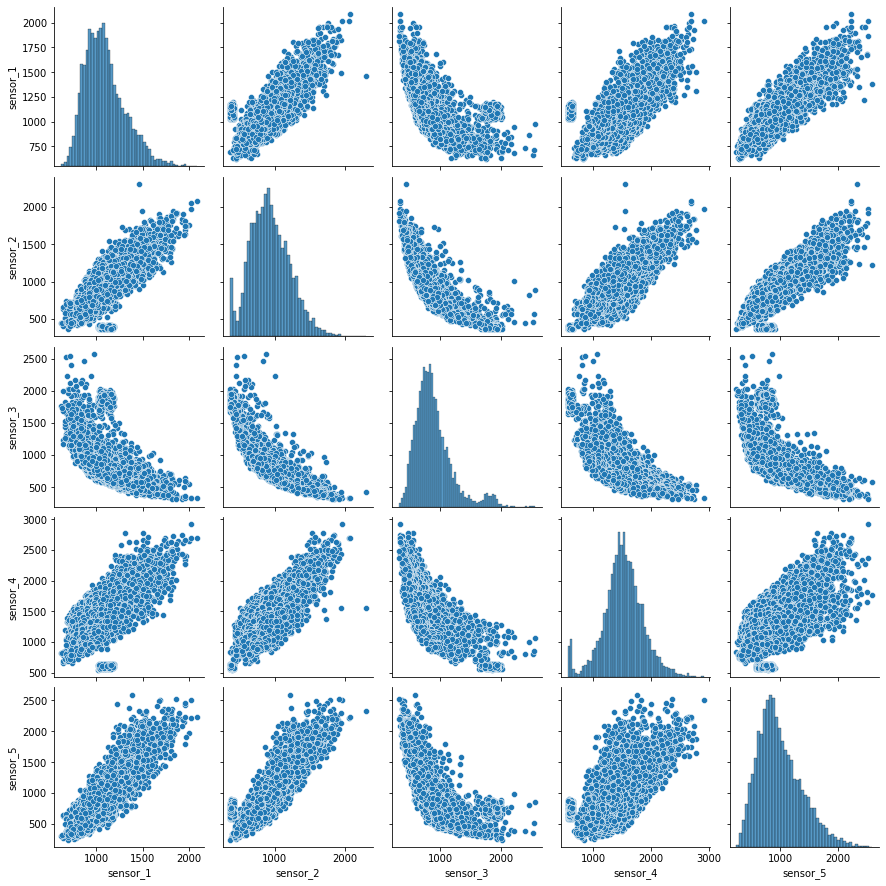

In [8]:
sns.pairplot(train_data[["sensor_1","sensor_2","sensor_3","sensor_4","sensor_5"]])

sensor1と2,4,5は正の相関があるっぽい。一方sensor1,2,4,5はsensor3と負の相関があるっぽい

**target_carbon_monoxide、target_benzene、target_nitrogen_oxideは異なるセンサー値によって制御されていると考える**

<Figure size 360x360 with 0 Axes>

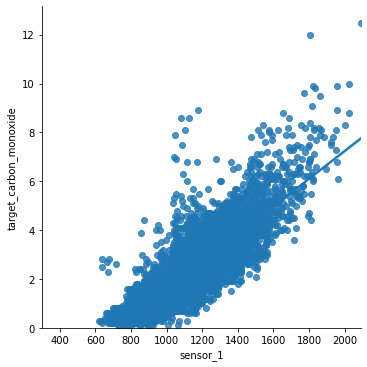

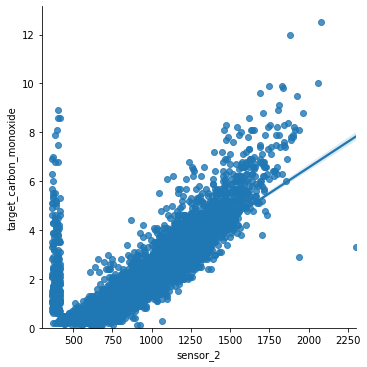

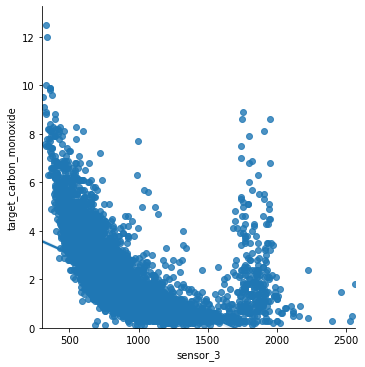

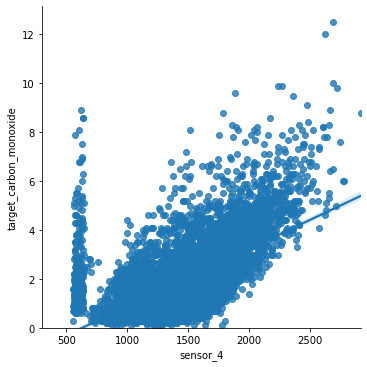

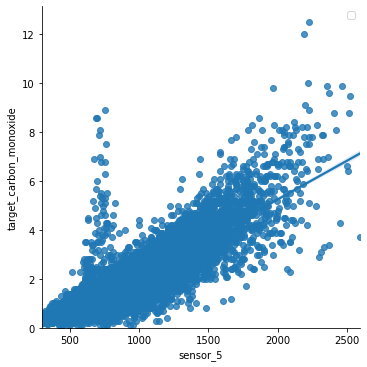

In [9]:
#target_carbon_monoxide
plt.figure(figsize=(5,5))

for i in range(1,6):
    g=sns.lmplot(data=train_data,x="sensor_"+str(i),y="target_carbon_monoxide")
    g.set(xlim=(300, None),ylim=(0,None))

plt.legend()

target_carbon_monoxideに関係なさそうなもの。

①sensor2が420以下の値のデータ
②sensor3が1500から2000のデータ
③sensor4が600以下のデータ
④sensor5が600~800付近のデータ

ただし、これら4つのデータがお互いに関係しているなら、これらを消去するとまずい？
あとで確認しておこう。

**実際にデータをいじっていこう**

In [10]:
X=train_data[["sensor_1","sensor_2","sensor_3","sensor_4","sensor_5"]]
y=train_data[["target_carbon_monoxide","target_benzene","target_nitrogen_oxides"]]

y_carbon=train_data["target_carbon_monoxide"]
y_benzene=train_data["target_benzene"]
y_no=train_data["target_nitrogen_oxides"]

In [11]:
#パラメータ調節
def param():
    param_grid= {
        'n_estimators':[5,10,15,25,50,100],
        'num_leaves': [5,10,15,30],
        'learning_rate': [0.01,0.05,0.1]
    } 
    return param_grid

model=lgbm.LGBMRegressor(
    random_state=42
)


#target_carbone_monoxideについて
grid_search_carbon = GridSearchCV(
    model,
    param(),
    cv=KFold(n_splits=5),
    n_jobs=-1
)

grid_search_carbon.fit(
    X,
    y_carbon,
    #eval_set=(val_x_carbon,val_y_carbon),
    eval_metric=RMSLE,
)


print(grid_search_carbon.best_params_)
print(grid_search_carbon.best_score_)

{'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 5}
0.8243819385781045


In [12]:
best_carbon_model=lgbm.LGBMRegressor(learning_rate=0.1,n_estimators=50, num_leaves=5,random_state=42)
best_carbon_model.fit(X,y_carbon,eval_metric=RMSLE)
carbon_preds=best_carbon_model.predict(test_data[["sensor_1","sensor_2","sensor_3","sensor_4","sensor_5"]])

In [13]:
#target_benzene
grid_search_benzene = GridSearchCV(
    model,
    param(),
    cv=KFold(n_splits=5),
    n_jobs=-1
)

grid_search_benzene.fit(
    X,
    y_benzene,
    #eval_set=(val_x_carbon,val_y_carbon),
    eval_metric=RMSLE,
    #categorical_feature=categorical_columns
    #lightGBMはCategorical Featureの設定によって、one-hot encodingより良い精度を出す。
    #その代わり、カテゴリ変数を整数(int)でエンコードする必要がある。
    #https://qiita.com/sinchir0/items/b038757e578b790ec96a
)

print(grid_search_benzene.best_params_)
print(grid_search_benzene.best_score_)

{'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 5}
0.9694561892008926


In [14]:
best_benzene_model=lgbm.LGBMRegressor(learning_date=0.1,n_estimators=100 , num_leaves=5,random_state=42)
best_benzene_model.fit(X,y_benzene,eval_metric=RMSLE)
benzene_preds=best_benzene_model.predict(test_data[["sensor_1","sensor_2","sensor_3","sensor_4","sensor_5"]])

In [15]:
#target_nitrogen_oxideについて
grid_search_no = GridSearchCV(
    model,
    param(),
    cv=KFold(n_splits=5),
    n_jobs=-1
)

grid_search_no.fit(
    X,
    y_no,
    #eval_set=(val_x_carbon,val_y_carbon),
    eval_metric=RMSLE,
    #categorical_feature=categorical_columns
    #lightGBMはCategorical Featureの設定によって、one-hot encodingより良い精度を出す。
    #その代わり、カテゴリ変数を整数(int)でエンコードする必要がある。
    #https://qiita.com/sinchir0/items/b038757e578b790ec96a
)

print(grid_search_no.best_params_)
print(grid_search_no.best_score_)

{'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 10}
0.15967972220263074


In [16]:
best_no_model=lgbm.LGBMRegressor(learning_rate=0.05,n_estimators=100 , num_leaves=10,random_state=42)
best_no_model.fit(X,y_no,eval_metric=RMSLE)
no_preds=best_no_model.predict(test_data[["sensor_1","sensor_2","sensor_3","sensor_4","sensor_5"]])

In [17]:
sample_submission=pd.read_csv("/kaggle/input/tabular-playground-series-jul-2021/sample_submission.csv")
sample_submission

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,2.0,10.0,300.0
1,2011-01-01 01:00:00,2.0,10.0,300.0
2,2011-01-01 02:00:00,2.0,10.0,300.0
3,2011-01-01 03:00:00,2.0,10.0,300.0
4,2011-01-01 04:00:00,2.0,10.0,300.0
...,...,...,...,...
2242,2011-04-04 10:00:00,2.0,10.0,300.0
2243,2011-04-04 11:00:00,2.0,10.0,300.0
2244,2011-04-04 12:00:00,2.0,10.0,300.0
2245,2011-04-04 13:00:00,2.0,10.0,300.0


In [18]:
output = pd.DataFrame(
    {
        'date_time':sample_submission["date_time"],
        "target_carbon_monoxide":carbon_preds,
        "target_benzene":benzene_preds,
        "target_nitrogen_oxides":no_preds,
    }
)

output.to_csv('my_submission#1.csv',index=False)
print(output.head())

print("my submission was successfully saved!")

             date_time  target_carbon_monoxide  target_benzene  \
0  2011-01-01 00:00:00                1.906067        5.615829   
1  2011-01-01 01:00:00                2.386673        8.127219   
2  2011-01-01 02:00:00                2.200080        7.745854   
3  2011-01-01 03:00:00                2.219019        8.921441   
4  2011-01-01 04:00:00                1.622357        6.847972   

   target_nitrogen_oxides  
0              322.051720  
1              375.609515  
2              385.628614  
3              379.011729  
4              299.260211  
my submission was successfully saved!
